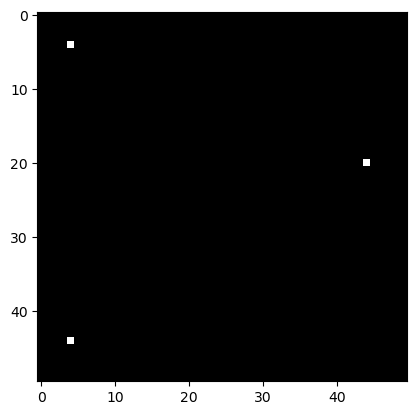

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 50x50 grid filled with zeros (black)
grid = np.zeros((50, 50))

# Set a couple of white elements by specifying their positions
# For example, let's set the element at row 10, column 20 and row 30, column 40 to white.
grid[4, 4] = 1  # White
grid[44, 4] = 1  # White
grid[20, 44] = 1  # White

# Display the grid
plt.imshow(grid, cmap='gray', interpolation='nearest')
plt.show()


In [2]:
import matplotlib.pyplot as plt
import pickle

import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

path_results = '/net/travail/jpenatrapero/results/results_3_3_imagenet_original.pkl'
with open(path_results, 'rb') as file:
    data = pickle.load(file)

# Read the class labels from the file
with open('imagenet1klabels.txt', 'r') as file:
    class_labels_dict = eval(file.read())
# List the keys in the dictionary
keys = data.keys()




# Create an image (replace this with your matrix)
matrix = data['Matrix_0']  # Your 50x50 matrix of class labels

def on_click(event):
    if event.inaxes is not None:
        x, y = int(event.xdata), int(event.ydata)
        value = matrix[y, x]
        ax.set_title(f'Value at ({x}, {y}): {value}')
# Create a sample 50x50 matrix (you can use your own data)

# Define a colormap for different colors
cmap = plt.get_cmap('viridis')  # You can choose a different colormap

# Create a figure and axis for the plot
fig, ax = plt.subplots()
# Plot asterisk, triangle, and square
ax.plot(4, 4, marker='*', markersize=10, color='red', markeredgecolor='black')
ax.plot(44, 4, marker='^', markersize=10, color='blue', markeredgecolor='black')
ax.plot(20, 44, marker='s', markersize=10, color='green', markeredgecolor='black')


# Plot the matrix as an image with colors
img = ax.imshow(matrix, cmap=cmap)

# Add a colorbar for reference
cbar = plt.colorbar(img)




# Connect the click event to the function
fig.canvas.mpl_connect('button_press_event', on_click)

# Display the figure with interactivity
plt.show()




FileNotFoundError: [Errno 2] No such file or directory: '/net/travail/jpenatrapero/results/results_3_3_imagenet_original.pkl'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import random
import pickle
import time
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import os
import argparse
import time
import sys

from model import get_model
from data import get_data, make_planeloader
from utils import get_loss_function, get_scheduler, get_random_images, produce_plot, get_noisy_images, AttackPGD
from evaluation import train, test, test_on_trainset, decision_boundary, test_on_adv
from options import options
from utils import simple_lapsed_time
from myFunctions import *
from utils import produce_plot_sepleg_IMAGENET #TODO : fix representation of images
import numpy as np

: 

In [22]:


#Important Note! -> Change the model loading in the intialization
load_net = '/net/travail/jpenatrapero/dbViz/pretrained_models/resnet18-5c106cde.pth'
net_name = 'resnet' 
set_seed = 777
set_data_seed = 1
save_net = 'saves'
imgs = 600,4000,1600
epochs = 2
lr = 0.01
resolution = 50 #Default is 500 and it takes 3 mins
batch_size_planeloader = 1
saveplot = False
num_classes = 3
num_images_experiment = 3
idx_pred_im = [11,81,68]#Fixed values with the indexes corresponding 
#to our original images in the format of the vector pred
# the class_pred[idx_pred_im[1]] is the predicted class for the first imae of the triplet

c1= "n02106662" #German shepard
c2= "n03388043" #Fountain
c3= "n03594945" #Jeep
#Labesl of the imagenet
labels = ['German_shepherd','fountain','jeep']
ground_truth_im = [235,562,609]

#Saving the results
results_folder = "results"
model_name = 'resnet50' #Name of the model for saved data

# Log of the results
active_log = False


device = 'cuda' if torch.cuda.is_available() else 'cpu'

if torch.cuda.is_available():
    print("CUDA IS AVALIABLE $.$ ")
else:
    print("No cuda avaliable :´( ")

CUDA IS AVALIABLE $.$ 


In [23]:
# Data/other training stuff
import torchvision.models as models
torch.manual_seed(set_data_seed)
torch.manual_seed(set_seed)
test_accs = []
train_accs = []


# Train or load base network
print("Training the network or loading the network")

start = time.time()
best_acc = 0  # best test accuracy
best_epoch = 0


#########################################################
#   LOADING THE NETWORK
#########################################################
net = models.resnet18(pretrained=True)
net.load_state_dict(torch.load(load_net))
    

# test_acc, predicted = test(args, net, testloader, device)
# print(test_acc)
end = time.time()
simple_lapsed_time("Time taken to load the model", end-start)


Training the network or loading the network
Time taken to load the model: 00:00:00.27


In [24]:
##############  DATASET   #################
imgs = 'imagenet'
start = time.time()
if imgs is None:
    print("imgs is None -> You need to provide the images to load")

elif imgs == 'handcrafted':
    path_to_db= "OODatasets/handcrafted/"
    imgCombinationsTensor, filenames_combinations = getCombiFromDB(c1, c2, c3,path_to_db)

elif imgs == 'signal':
    path_to_db= "OODatasets/signal/"
    imgCombinationsTensor, filenames_combinations = getCombiFromDB(c1, c2, c3,path_to_db)

elif imgs == 'generated':
    path_to_db= "OODatasets/generated/"
    imgCombinationsTensor, filenames_combinations = getCombiFromDB(c1, c2, c3,path_to_db)

elif imgs == 'imagenet':
    path_to_db= "OODatasets/imagenet_val_resized/"
    imgCombinationsTensor, filenames_combinations = getCombiFromDB(c1, c2, c3,path_to_db)

elif imgs == 'test10images':
    path_to_db= "/net/cremi/jpenatrapero/DATASETS/10images/"
    imgCombinationsTensor, filenames_combinations = getCombiFromDB(c1, c2, c3,path_to_db)
else:
    print('UNRECOGNICED image dataset')

sampleids = '_'.join(list(map(str,labels)))

n_combis = num_images_experiment**num_classes

accuracy_triplet = []
margin_triplet = []
results_all_pred = {}  # Initialize an empty dictionary to store pred matrices


In [30]:
arg = types.SimpleNamespace()
arg.net = net_name
arg.batch_size_planeloader = batch_size_planeloader
arg.resolution = 50
arg.bs = 128
arg.baseset = "CIFAR10"


In [33]:
args['resolution']

50

In [28]:
print('==> Starting loop through all triplet combinations..')
for i_triplet in range(n_combis):

    progress = (i_triplet + 1) / n_combis * 100
    print(f"Progress: {progress:.2f}% complete", end="\r", flush=True)

    images = imgCombinationsTensor[i_triplet]

    #Creating planeloader for the image space
    planeloader = make_planeloader(images, args)
    #Using the model to predict all the plane
    preds = decision_boundary(args, net, planeloader, device)

    #Getting the labels of the predictions
    preds = torch.stack((preds))
    temp=0.01 #Not sure what this does
    preds = nn.Softmax(dim=1)(preds / temp)
    class_vect = torch.argmax(preds, dim=1).cpu().numpy()

    #Converting vector to matrix
    pred_matrix  = np.reshape(class_vect, (resolution, resolution))

    results_all_pred[f"Matrix_{i_triplet}"] = pred_matrix
    results_all_pred[f"Combi_{i_triplet}"] = filenames_combinations[i_triplet]

    #accuracy_triplet, margin_triplet = margin_TRDP_I (class_pred,pred_matrix,idx_pred_im,ground_truth_im,accuracy_triplet,margin_triplet)


############# END OF FOR LOOP TRHOUGH ALL THE TRIPLETS

end = time.time()
simple_lapsed_time("Time taken for all combinatios of triplets", end-start)
# Calculate average margins for accurate predictions


save_results('/net/travail/jpenatrapero/results',results_all_pred,"results_3_3_imagenet_original.pkl")




==> Starting loop through all triplet combinations..


AttributeError: 'dict' object has no attribute 'resolution'